<a href="https://colab.research.google.com/github/anish-nagariya/Shopping-Prediction-Model/blob/main/StockPrediction_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from polygon import RESTClient
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation

In [38]:
API_KEY = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'
tickers = [
    'MSFT', 'AAPL', 'AMZN', 'GOOG', 'GOOGL',
    'FB', 'BRK.B', 'JNJ', 'V',
    'PG','JPM', 'UNH', 'MA', 'INTC', 'VZ',
    'HD', 'T', 'PFE', 'MRK', 'PEP'
    ]

In [65]:
def load_previous_data(ticker, api_key, multiplier, timespan):
    f = open('ticker_folder/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=multiplier, timespan=timespan,
                                                 from_='1999-07-12', to='2021-02-01', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp = resp.results
        f.write('o,l,h,v,c\n')
        for query in resp:
            f.write(str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
        f.close()

In [69]:
def get_minute_data(ticker, api_key, last_minutes):
    f = open('recent_ticker_data/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=1, timespan='minute',
                                                 from_='1999-07-12', to='2021-02-03', unadjusted=True,
                                                 sort='desc', limit=last_minutes)
        resp = resp.results
        f.write('o,l,v,c\n')
        for query in resp:
            f.write(str(query['o']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
        f.close()
get_minute_data('GOOG', API_KEY, 50)

In [42]:
def get_all_news(ticker, api_key):
    f = open(ticker + '_news.csv', 'w')
    f.write('date,title\n')
    with RESTClient(api_key) as client:
        for j in range(35):
            resp = client.reference_ticker_news(symbol=ticker, perpage=50, page=j)
            for i in range(50):
                f.write(resp.news[i].timestamp + ',' + resp.news[i].title + '\n')

In [63]:
def get_polarity(headline):
    analysis = TextBlob(headline)
    return analysis.polarity
get_polarity("The Apple Franchise Has Significant Upside, Says Munster")

0.375

In [10]:
def split_data(ticker):
    data = pd.read_csv('ticker_folder/' + ticker + '.csv')
    days = len(data)
    data_training = data[:days - 60]
    data_testing = data[days - 60:]
    scaler = MinMaxScaler()
    training_data = data_training.copy()
    data_training = scaler.fit_transform(data_training)
    x_train, y_train, x_test, y_test = [], [], [], []

    for i in range(60, data_training.shape[0]):
        x_train.append(data_training[i - 60: i])
        y_train.append(data_training[i, 0])

    past_60_days = training_data.tail(60)
    df = past_60_days.append(data_testing, ignore_index=True)
    inputs = scaler.transform(df)

    for i in range(60, inputs.shape[0]):
        x_test.append(inputs[i - 60:i])
        y_test.append(inputs[i, 0])

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    return x_train, y_train, x_test, y_test, scaler.scale_[0]


In [27]:
def create_rnn():
    model = Sequential()

    model.add(Bidirectional(LSTM(units=50, activation='relu', input_shape=(60, 5), return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=80, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=100, activation='relu', return_sequences=True)))
    model.add(Dropout(0.1))

    model.add(Bidirectional(LSTM(units=120, activation='relu', return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Activation('linear'))

    model.add(Dense(units=50))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    return model

In [43]:
def plot_prediction(y_test, y_predictions, ticker):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, c='r', label='Real ' + ticker + ' stock price')
    plt.plot(y_predictions, c='b', label='Predicted ' + ticker + ' stock price')
    plt.xlabel('time')
    plt.ylabel(ticker + ' Stock Price')
    plt.legend()
    plt.show()

In [73]:
def create_model(ticker):
    load_previous_data(ticker=ticker, api_key=API_KEY, multiplier=1, timespan='day')
    x_train, y_train, x_test, y_test, scaler = split_data(ticker)

    model = create_rnn()
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
    )
    model.fit(
        x_train, y_train, epochs=500, batch_size=512, validation_split=0.1
    )
    predictions = model.predict(x_test)
    model.save('models/' + ticker)

    scale = 1 / scaler
    predictions = predictions * scale
    y_test = y_test * scale
    plot_prediction(y_test, predictions, ticker)

    return

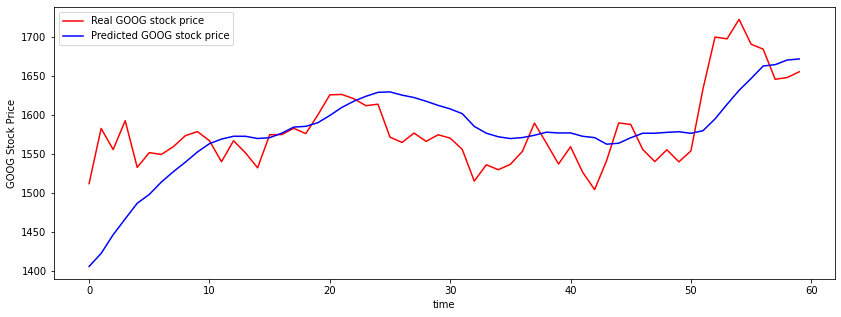

In [56]:
def load_model(ticker):
    model = keras.models.load_model('models/' + ticker)
    x_train, y_train, x_test, y_test, scaler = split_data(ticker)
    predictions = model.predict(x_test)

    scale = 1 / scaler
    predictions = predictions * scale
    y_test = y_test * scale
    plot_prediction(y_test, predictions, ticker)

    return

load_model('GOOG')

In [49]:
def main():
    create_model('GOOG')

In [ ]:
if __name__ == "__main__":
    main()


Epoch 1/500
8/8 [==============================] - 48s 4s/step - loss: 0.0943 - val_loss: 0.0136
Epoch 2/500
8/8 [==============================] - 35s 4s/step - loss: 0.0176 - val_loss: 0.0164
Epoch 3/500
8/8 [==============================] - 34s 4s/step - loss: 0.0128 - val_loss: 0.0054
Epoch 4/500
8/8 [==============================] - 34s 4s/step - loss: 0.0075 - val_loss: 0.0013
Epoch 5/500
8/8 [==============================] - 33s 4s/step - loss: 0.0066 - val_loss: 0.0015
Epoch 6/500
8/8 [==============================] - 33s 4s/step - loss: 0.0040 - val_loss: 0.0011
Epoch 7/500
3/8 [==========>...................] - ETA: 21s - loss: 0.0033